## 1.0a Taxi Data - Preprocessing

In this first notebook, the main dataframe is preprocessed. This includes:
- Loading the data
- Changing its datatypes
- Dropping trivial or null columns/rows
- Splitting the data into subsets and saving them for further work

As the original data is rather large in size, it is not included in the repository. Instead, when wanting to run this notebook, it is necessary to:
1. Download the data from https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew#column-menu where you specify via Actions->Query Data->Trip Start Timestamp // In Between // 2022 Jan 01 12:00:00 AM AND 2022 Dec 31 11:59:59 PM
2. Rename the file to "taxidata"
3. Run the code cell below and add the data to the following directory

In [1]:
import os
# this directory for the original data file
os.makedirs('./data', exist_ok=True)
# this directory to later save the prepared data
os.makedirs('./data/prepped', exist_ok=True)

In [2]:
# Standard libraries - run pip install if necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

# Geospatial libraries
from h3 import h3 
import geopandas as gp
import folium
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon
## Color for map 
import branca
import branca.colormap as cm

### 1.1 Read and display datafile

In [3]:
# Data file not included in the project, needs to be downloaded individually. This step can take a few minutes due to size of the original file
df = pd.read_csv("data/taxidata.csv")

In [4]:
df.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31T23:45:00.000,2023-01-01T00:15:00.000,2081.0,4.42,NaN,NaN,2.0,3.0,...,0.0,20.50,Prcard,Flash Cab,42.001571,-87.695013,POINT (-87.6950125892 42.001571027),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31T23:45:00.000,2023-01-01T00:00:00.000,812.0,0.00,NaN,NaN,8.0,24.0,...,0.0,16.57,Mobile,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941)
2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31T23:45:00.000,2023-01-01T00:00:00.000,600.0,0.90,NaN,NaN,8.0,8.0,...,3.0,12.00,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
3,38292159642750da7b20419330566f9eb0961cde,81092e4881f56106fae845c3ae4492f8b3c3213c33c920...,2022-12-31T23:45:00.000,2023-01-01T00:00:00.000,546.0,0.85,NaN,NaN,8.0,8.0,...,0.0,6.50,Cash,Taxicab Insurance Agency Llc,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
4,3e01498f8ff771ad7eb37e4844cef20201b6c339,4ae32e2eb244ce143800e0c40055e537cc50e3358a07ce...,2022-12-31T23:45:00.000,2023-01-01T00:00:00.000,574.0,0.33,NaN,NaN,8.0,8.0,...,0.0,6.25,Cash,City Service,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)


In [5]:
# Data types
df.dtypes

trip_id                        object
taxi_id                        object
trip_start_timestamp           object
trip_end_timestamp             object
trip_seconds                  float64
trip_miles                    float64
pickup_census_tract           float64
dropoff_census_tract          float64
pickup_community_area         float64
dropoff_community_area        float64
fare                          float64
tips                          float64
tolls                         float64
extras                        float64
trip_total                    float64
payment_type                   object
company                        object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location       object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location      object
dtype: object

In [6]:
# Convert time types to check if entries are from correct range
df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"])
df["trip_end_timestamp"] = pd.to_datetime(df["trip_end_timestamp"])

# Convert other 
df["trip_seconds"] =  pd.to_numeric(df['trip_seconds'])

# In range of 2022:
print(f"Min date: {df['trip_start_timestamp'].min()}")
print(f"Max date: {df['trip_start_timestamp'].max()}")

Min date: 2022-01-01 00:00:00
Max date: 2022-12-31 23:45:00


Make sure these are the right dates, here it should say **2022-01-01 00:00:00** and **2022-12-31 23:45:00**. 

In [7]:
# Look into null values
print(f"General shape of dataframe: {df.shape}")
print(df.isna().sum())

General shape of dataframe: (6382425, 23)
trip_id                             0
taxi_id                           354
trip_start_timestamp                0
trip_end_timestamp                212
trip_seconds                     1465
trip_miles                         56
pickup_census_tract           3758594
dropoff_census_tract          3707094
pickup_community_area          513853
dropoff_community_area         633684
fare                             3536
tips                             3536
tolls                            3536
extras                           3536
trip_total                       3536
payment_type                        0
company                             0
pickup_centroid_latitude       511551
pickup_centroid_longitude      511551
pickup_centroid_location       511551
dropoff_centroid_latitude      597931
dropoff_centroid_longitude     597931
dropoff_centroid_location      597931
dtype: int64


In [8]:
df.columns

Index(['trip_id', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'payment_type', 'company', 'pickup_centroid_latitude',
       'pickup_centroid_longitude', 'pickup_centroid_location',
       'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
       'dropoff_centroid_location'],
      dtype='object')

In [9]:
df.dtypes

trip_id                               object
taxi_id                               object
trip_start_timestamp          datetime64[ns]
trip_end_timestamp            datetime64[ns]
trip_seconds                         float64
trip_miles                           float64
pickup_census_tract                  float64
dropoff_census_tract                 float64
pickup_community_area                float64
dropoff_community_area               float64
fare                                 float64
tips                                 float64
tolls                                float64
extras                               float64
trip_total                           float64
payment_type                          object
company                               object
pickup_centroid_latitude             float64
pickup_centroid_longitude            float64
pickup_centroid_location              object
dropoff_centroid_latitude            float64
dropoff_centroid_longitude           float64
dropoff_ce

In [10]:
# Convert trip duration to hours/km for easier visualization later
df['trip_km'] = df['trip_miles'] * 1.609344
df['trip_hours'] = df['trip_seconds'] / 3600

In [11]:
# ------------------ Columns we do/will not work with can be dropped here ------------------
# print("number of entries where column tolls is filled", len(df[df["tolls"] > 0]), "percentage of positive values in this column: ",  (len(df[df["tolls"] > 0])/len(df))) tolls 0.001 entries filled

In [12]:
df.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,trip_km,trip_hours
0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,2.0,3.0,...,Prcard,Flash Cab,42.001571,-87.695013,POINT (-87.6950125892 42.001571027),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),7.113300,0.578056
1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,8.0,24.0,...,Mobile,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),0.000000,0.225556
2,3f5cd3f78e5cab455606a31372a95d3204b2fb3f,847cf962bd6f62040673e6c24c24940aeb2d7fdaa54677...,2022-12-31 23:45:00,2023-01-01 00:00:00,600.0,0.90,NaN,NaN,8.0,8.0,...,Credit Card,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),1.448410,0.166667
3,38292159642750da7b20419330566f9eb0961cde,81092e4881f56106fae845c3ae4492f8b3c3213c33c920...,2022-12-31 23:45:00,2023-01-01 00:00:00,546.0,0.85,NaN,NaN,8.0,8.0,...,Cash,Taxicab Insurance Agency Llc,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),1.367942,0.151667
4,3e01498f8ff771ad7eb37e4844cef20201b6c339,4ae32e2eb244ce143800e0c40055e537cc50e3358a07ce...,2022-12-31 23:45:00,2023-01-01 00:00:00,574.0,0.33,NaN,NaN,8.0,8.0,...,Cash,City Service,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),0.531084,0.159444


### 1.2 Checking data logic & removing invalid data

#### 1.2.1 Duplicate entries

In [13]:
# Check duplicates 
print("Number of duplicate entries: ", df.duplicated(subset = ['taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 
                                                              'pickup_census_tract','dropoff_census_tract','pickup_community_area', 'dropoff_community_area',
                                                              'pickup_centroid_latitude','pickup_centroid_longitude','pickup_centroid_location','dropoff_centroid_latitude',
                                                              'dropoff_centroid_longitude','dropoff_centroid_location']).sum())

Number of duplicate entries:  21772


In [14]:
df = df.drop_duplicates(subset = ['taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 
                                                              'pickup_census_tract','dropoff_census_tract','pickup_community_area', 'dropoff_community_area',
                                                              'pickup_centroid_latitude','pickup_centroid_longitude','pickup_centroid_location','dropoff_centroid_latitude',
                                                              'dropoff_centroid_longitude','dropoff_centroid_location'], keep='first')
df.shape

(6360653, 25)

#### 1.2.2 Time Logic - TODO

First do some start/end time checks

In [15]:
print(f"Number of rows where starttime > endtime: {len(df[df['trip_start_timestamp'] > df['trip_end_timestamp']])}")

Number of rows where starttime > endtime: 122


In [16]:
# Drop where <=
## Time equality allowed since trips are only saved in specific time interval (trip could have been too short for right recording of the time)
df = df[df["trip_start_timestamp"] <= df["trip_end_timestamp"]]

In [17]:
# Entries where start = endtime, trip miles = seconds = 0, dropoff = pickup coordinates (centroids & census)
print("Number of rows where starttime equals endtime, trip seconds and miles = 0, and dropoff/pickup location and census are the same:", len(df[(df['trip_start_timestamp'] == df['trip_end_timestamp']) &
(df['trip_seconds'] == 0) & (df['trip_miles'] == 0) & (df['pickup_centroid_location'] == df['dropoff_centroid_location']) & (df['pickup_census_tract'] == df['dropoff_census_tract'])]))

Number of rows where starttime equals endtime, trip seconds and miles = 0, and dropoff/pickup location and census are the same: 47447


In [18]:
# TODO: Drop these? or more checks
df = df[~((df['trip_start_timestamp'] == df['trip_end_timestamp']) &
(df['trip_seconds'] == 0) & (df['trip_miles'] == 0) & (df['pickup_centroid_location'] == df['dropoff_centroid_location']) & (df['pickup_census_tract'] == df['dropoff_census_tract']))]

Look at the "trip_seconds" column next.

In [19]:
# Maximal time duration
## Looking at googlemaps/the county's neighborhoods, from most northern to most southern trip it takes around 1h 20min + traffic at most 4h? (worst traffic fridays between 4 p.m. and 5 p.m.)
print("Max trip seconds:", df["trip_seconds"].max()) # Max is 86341 sec ~ 1 day 
print("Number of rows with unreasonable trip_seconds (more than 4h):", len(df[(df['trip_seconds'] > 14400)]))

Max trip seconds: 86341.0
Number of rows with unreasonable trip_seconds (more than 4h): 7052


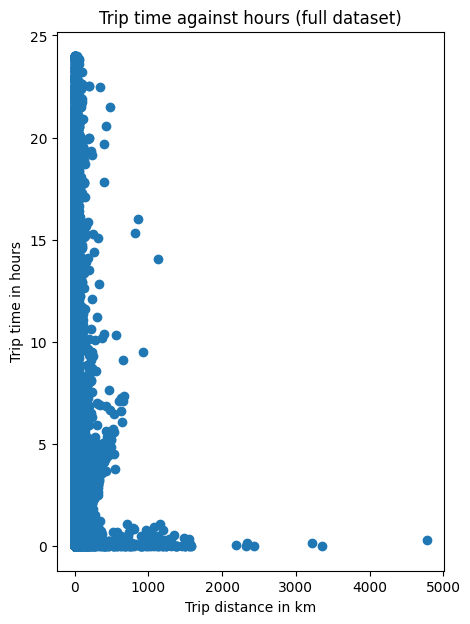

In [20]:
fig, ax = plt.subplots(figsize=(5,7))
ax.scatter(df['trip_km'], df['trip_hours'])
ax.set_xlabel('Trip distance in km')
ax.set_ylabel('Trip time in hours')
ax.set_title("Trip time against hours (full dataset)")
plt.show()

From this we can see a lot of trips that do not have a lot of miles but time that has passed. This could be due to the specific time intervals trips take place in. For instance, if a trip is less than 15 min long, this would not be recorded properly and instead have assigned 0 miles or 0 sec trip time. Still, we should **disregard** extreme outliers, e.g. such that have **trip_total > 3h (10.800 sec)** (for the time consider the most northern & southern neighborhoods of Cook county, which is approx. 1,2h long and in worst traffic scenario (e.g. Fridays at 4.00 to 5.00pm) => we get 3h)

Number of affected rows:  186


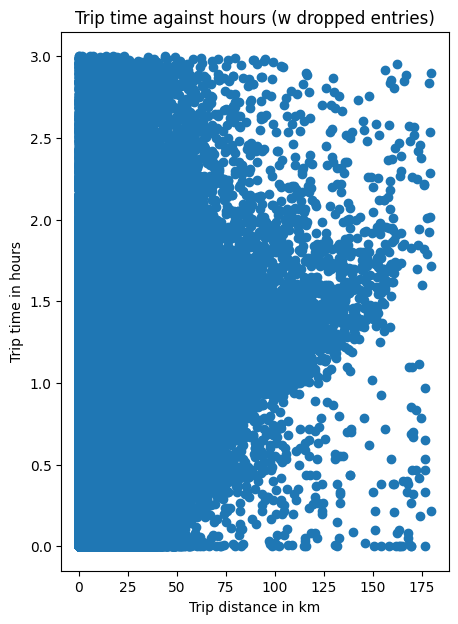

In [21]:
# TODO/DISCUSS: Which entries should we drop? Drop miles + seconds or only unreasonable seconds?
print("Number of affected rows: ", len(df[(df["trip_seconds"] > 10800) & (df["trip_km"] > 180)]))
# Logical AND/OR ?
df = df[(df["trip_seconds"] <= 10800) & (df["trip_km"] <= 180)]

fig, ax = plt.subplots(figsize=(5,7))
ax.scatter(df["trip_km"], df["trip_hours"])
ax.set_xlabel('Trip distance in km')
ax.set_ylabel('Trip time in hours')
ax.set_title("Trip time against hours (w dropped entries)")
plt.show()

#### 1.2.3 Trip Logic - TODO

In [22]:
cols = ['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras', 'trip_total']
for col in cols:
        print(f"Number of rows with negative values in {col}: {len(df[df[col] < 0])}")

Number of rows with negative values in trip_seconds: 0
Number of rows with negative values in trip_miles: 0
Number of rows with negative values in fare: 0
Number of rows with negative values in tips: 0
Number of rows with negative values in tolls: 0
Number of rows with negative values in extras: 0
Number of rows with negative values in trip_total: 0


In [23]:
# This can be explained through missing values for one of the columns, so we can still include them
other_total = df[df['trip_total'] != df['fare'] + df['tips'] + df['tolls'] + df['extras']]
print(f"Number of rows where trip_total does not match sum of fare, tips, tolls, and extras: {len(other_total)}")
# df[df['trip_total'] != df['fare'] + df['tips'] + df['tolls'] + df['extras']]

Number of rows where trip_total does not match sum of fare, tips, tolls, and extras: 1844768


In [24]:
# TODO: Do some checks concerning...
print(f"Number of rows with no census and no community (PICKUP): {len(df[df['pickup_census_tract'].isna() & df['pickup_community_area'].isna()])}")
print(f"Number of rows with no census and no community (DROPOFF): {len(df[df['dropoff_census_tract'].isna() & df['dropoff_community_area'].isna()])}")
# Rows we should drop
print("\n")
print("Number of rows with no census and no community (BOTH): ",len(df[df['pickup_census_tract'].isna() 
                                                                       & df['pickup_community_area'].isna() & df['dropoff_census_tract'].isna() & df['dropoff_community_area'].isna()]))
print(f"Number of rows with no community DROPOFF and no community PICKUP: {len(df[df['pickup_centroid_location'].isna() & df['dropoff_centroid_location'].isna()])}")


Number of rows with no census and no community (PICKUP): 507118
Number of rows with no census and no community (DROPOFF): 586044


Number of rows with no census and no community (BOTH):  224130
Number of rows with no community DROPOFF and no community PICKUP: 225948


### 1.3 Checking null values

In [25]:
df.isna().sum()

trip_id                             0
taxi_id                           347
trip_start_timestamp                0
trip_end_timestamp                  0
trip_seconds                        0
trip_miles                          0
pickup_census_tract           3737624
dropoff_census_tract          3685880
pickup_community_area          509905
dropoff_community_area         628415
fare                             3331
tips                             3331
tolls                            3331
extras                           3331
trip_total                       3331
payment_type                        0
company                             0
pickup_centroid_latitude       507782
pickup_centroid_longitude      507782
pickup_centroid_location       507782
dropoff_centroid_latitude      592875
dropoff_centroid_longitude     592875
dropoff_centroid_location      592875
trip_km                             0
trip_hours                          0
dtype: int64

#### 1.3.1 Time null values

In [26]:
# Drop entries where trip seconds are null and time is equal
print("Entries where no trip seconds but start and end time are also equal ", len(df[df["trip_seconds"].isna() & (df["trip_start_timestamp"] ==  df["trip_end_timestamp"])]))
print("Entries where no trip seconds but start and end time different ", len(df[df["trip_seconds"].isna() & (df["trip_start_timestamp"] !=  df["trip_end_timestamp"])]))

Entries where no trip seconds but start and end time are also equal  0
Entries where no trip seconds but start and end time different  0


In [27]:
# Drop where cannot be calculated:
df = df[~(df["trip_seconds"].isna() & (df["trip_start_timestamp"] ==  df["trip_end_timestamp"]))]

# Else calculate the trip seconds:
temp_trip = df[df["trip_seconds"].isna() & (df["trip_start_timestamp"] !=  df["trip_end_timestamp"])].copy()
temp_trip["calculated_trip_seconds"] = (temp_trip["trip_end_timestamp"] - temp_trip["trip_start_timestamp"]).dt.seconds
df["trip_seconds"].fillna(temp_trip["calculated_trip_seconds"], inplace=True)

df["trip_seconds"].isna().sum()

0

#### Further checks...

### 1.4 Hexagons - res8 and res7 takes too long (deswegen erstmal ausgeklammert)

In [33]:
# Get hex ids
def add_h3_ids(df, res):
    df[f"h3_res{res}_pickup"] = np.vectorize(h3.geo_to_h3)(
        df['pickup_centroid_latitude'], df['pickup_centroid_longitude'], res)
    df[f"h3_res{res}_dropoff"] = np.vectorize(h3.geo_to_h3)(
        df['dropoff_centroid_latitude'], df['dropoff_centroid_longitude'], res)
    return df

# Get poly from hex ids - vectorized form to save time
def poly_from_hex(df, colname, res):
    hex_ids = df[f"h3_res{res}_{colname}"].values
    polygons = np.vectorize(lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True)))(hex_ids)
    df[f"poly_res{res}_{colname}"] = polygons
    return df

# Get count for each trip happening in the same hexagon
def get_poly_count(df, colname):
    name = colname.split("_")[1] + "_" + colname.split("_")[2]
    df[f"count{name}"] = df.groupby(colname)['trip_id'].transform('count')
    return df

In [29]:
# For hexagon resolution, adapted: https://towardsdatascience.com/exploring-location-data-using-a-hexagon-grid-3509b68b04a2 table
hex_df = add_h3_ids(df, 7)
#hex_df = add_h3_ids(df, 8)

In [30]:
# Entries where hex id is 0, we cannot use for visualization, hence drop
## TODO: maybe if census tract is given/community area, we can use this to merge with later census data to get hexagons for these entries? 
print("Number of hex ids equal to 0: ",len(hex_df[(hex_df["h3_res7_pickup"] == "0") | (hex_df["h3_res7_dropoff"] == "0")]))

hex_df_clear = hex_df[(hex_df["h3_res7_pickup"] != "0") & (hex_df["h3_res7_dropoff"] != "0")]

Number of hex ids equal to 0:  874709


In [31]:
hex_df_clear.head(2)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,trip_km,trip_hours,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff
0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,2.0,3.0,...,POINT (-87.6950125892 42.001571027),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),7.1133,0.578056,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff
1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,8.0,24.0,...,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),0.0000,0.225556,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff


In [34]:
# Get polygon from hex ids
hex_df_poly = poly_from_hex(hex_df_clear, "pickup", 7)
#hex_df_poly = poly_from_hex(hex_df_clear, "dropoff", 7)
# hex_df_poly = poly_from_hex(hex_df_clear, "pickup", 8)
# hex_df_poly = poly_from_hex(hex_df_clear, "dropoff", 8)

C:\Users\25mad\AppData\Local\Temp\ipykernel_29720\3325588696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"poly_res{res}_{colname}"] = polygons

KeyboardInterrupt



In [38]:
hex_df_poly.head(2)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,dropoff_centroid_longitude,dropoff_centroid_location,trip_km,trip_hours,h3_res7_pickup,h3_res7_dropoff,h3_res8_pickup,h3_res8_dropoff,poly_res7_pickup,poly_res7_dropoff
0,4404c6835b9e74e9f74d70f235200a8ce09db14a,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2022-12-31 23:45:00,2023-01-01 00:15:00,2081.0,4.42,NaN,NaN,2.0,3.0,...,-87.655879,POINT (-87.6558787862 41.96581197),7.1133,0.578056,872664d8effffff,872664d89ffffff,882664d8e1fffff,882664d897fffff,POLYGON ((-87.69707061396723 42.01260288298376...,POLYGON ((-87.65510606950835 41.98050464017767...
1,466473fd2a196ebe92fb2983cb7e8af32e39aa1f,d1d88b89ceb6d753007b6e795e3c24f4bea905a51e9d47...,2022-12-31 23:45:00,2023-01-01 00:00:00,812.0,0.00,NaN,NaN,8.0,24.0,...,-87.676356,POINT (-87.6763559892 41.9012069941),0.0000,0.225556,872664c1effffff,872664cacffffff,882664c1edfffff,882664cac3fffff,POLYGON ((-87.63048927308355 41.90755371098675...,POLYGON ((-87.68099468459282 41.91921142279649...


In [ ]:
# Get count for each polygon
hex_df_poly = get_poly_count(hex_df_poly, "poly_res7_pickup")
#hex_df_poly = get_poly_count(hex_df_poly, "poly_res7_dropoff")
# hex_df_poly = get_poly_count(hex_df_poly, "poly_res8_pickup")
# hex_df_poly = get_poly_count(hex_df_poly, "poly_res8_dropoff")

In [ ]:
#hex_df_clear.head(1)

In [ ]:
# Make a geodf out of it for simple plotting
gdf_res7_pickup = gp.GeoDataFrame(hex_df_clear, geometry=hex_df_poly['poly_res7_pickup'], crs='EPSG:4326')
gdf_res7_dropoff = gp.GeoDataFrame(hex_df_clear, geometry=hex_df_poly['poly_res7_dropoff'], crs='EPSG:4326')
# gdf_res8_pickup = gp.GeoDataFrame(hex_df_clear, geometry=hex_df_poly['poly_res8_pickup'], crs='EPSG:4326')
# gdf_res8_dropoff = gp.GeoDataFrame(hex_df_clear, geometry=hex_df_poly['poly_res8_dropoff'], crs='EPSG:4326')

#Visualize
# fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 10))

# titles = ["Hex resolution 7", 
#           # "Hex resolution 8"
#          ]
# dfs = [gdf_res7_pickup, gdf_res7_dropoff,  
#        # gdf_res8_pickup, gdf_res8_dropoff
#       ]

# axs = axs.flatten()
# for ind in range(0, 3):
#     dfs[ind].plot(column="count", ax=axs[ind], legend=True)
#     axs[ind].set_title(titles[ind])

# plt.tight_layout()
# plt.show()

In [ ]:
df_pickup_res8['geometry'] = df_pickup_res7.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_pickup_res8"], geo_json=True)), axis=1)
trips_starts_geo = gp.GeoDataFrame(df_pickup_res7, geometry=df_pickup_res7['geometry'], crs='EPSG:4326')
trips_starts_geo.head()

In [ ]:
trips_starts_geo.plot(column='count')

In [ ]:
# TODO: save data?

### 1.5 Census Data

Census tracts are "geographic entities within counties". Represented within the string of numbers, are the state, the county, and the tract code.
For more info on census read here: https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf. Entries generally follow the structure of 17031...., where:
- 17 is the state of Illinois
- 031 stands for Cook County
- And the last four digits make up the district within the county

In order to use given census data within our data, we additionally get data from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6, where Wikipedia offers also the corresponding names of each neighborhood area: https://en.wikipedia.org/wiki/Community_areas_in_Chicago#References. As these files are fairly small, we included them in the repository.

In [ ]:
census = gp.read_file("data/Boundaries - Census Tracts - 2010.geojson")
# Area names
area = gp.read_file("data/chicago_area.csv")
print(census.info())
census.head(3)

We can see that most important columns from this dataframe are "commarea" and "geoid10" which correspond to the dropoff/pickup community area and dropoff/pickup census tract columns of our main frame.

In [ ]:
# Drop columns, rename for merge
census = census.drop(columns= ['statefp10', 'name10', 'commarea_n', 'namelsad10', 'notes', 'tractce10', 'countyfp10',])

area = area.drop(["geometry"], axis=1)
area = area.rename(columns={"dropoff_community_area": "commarea"})

In [ ]:
# Merge dfs
df_census = census.merge(area, how="left", on="commarea")
df_census["commarea"] = df_census["commarea"].astype(int)
df_census = df_census.rename(columns={"geoid10": "geoid"})
print(df_census.dtypes)
df_census.head()

In [ ]:
#TODO: Maybe change to other color https://python-visualization.github.io/folium/latest/advanced_guide/colormaps.html#Draw-a-ColorMap-on-a-map
colormap = cm.linear.Set1_09.scale(df_census['commarea'].min(), df_census['commarea'].max()).to_step(df_census['commarea'].max()) 

colormap.caption = "Colorscale for different community areas"
colormap

In [ ]:
m = folium.Map(location = [41.88065, -87.62642], zoom_start=10, control_scale= True, width=600, height=700)

folium.GeoJson(df_census,
               tooltip=folium.GeoJsonTooltip(fields=['community_name']),
              style_function=lambda feature: {
                'fillColor': colormap(int(feature['properties']['commarea'])),
                'color': "white", 
                'weight':0.5, #border size
                'fillOpacity':0.9,
              }
              ).add_to(m)
m.add_child(colormap) # Can also be left out
m

In [ ]:
df[df["pickup_census_tract"].notna()].head()

In [ ]:
df_census.head()

In [ ]:
# Number of unique census tracts in our main df
uni = np.unique(np.concatenate(( df['pickup_census_tract'].unique(), df['dropoff_census_tract'].unique())))
uni = uni[~np.isnan(uni)]
print(len(uni)) 

# Number of unique census tracts in boundary df
print(len(df_census["geoid"].unique()))

In [ ]:
# TODO: merge on census_tract if possible else use commarea

In [ ]:
# Instead of having neighborhoods split up into multiple sections, apply unary_union to merge polygons into one
merged_polygons = df_census.groupby('commarea')['geometry'].apply(unary_union).reset_index()

result = merged_polygons.merge(df_census[['commarea', 'community_name', "geoid"]], on='commarea', how="right").drop_duplicates()
# To also get the geoIDs as some df entries do not have commarea but census tract given
# result = result.merge(df_census["geoid"], on="commarea", how="right")


neighborhood_df = result.set_geometry("geometry", crs = "EPSG:4326")

In [ ]:
m = folium.Map(location = [41.88065, -87.62642], zoom_start=10, control_scale= True, width=600, height=700)

folium.GeoJson(neighborhood_df,
               tooltip=folium.GeoJsonTooltip(fields=['community_name']),
              style_function=lambda feature: {
                'fillColor': colormap(int(feature['properties']['commarea'])),
                'color': "white", 
                'weight':0.5, #border size
                'fillOpacity':0.9,
              }
              ).add_to(m)
m

In [ ]:
# Save prepared data
neighborhood_df.to_file('data/prepped/census_tracts_df.geojson', driver = 'GeoJSON')

In [ ]:
# Can merge main frame on geoid - commarea but can be done later on as well